# VAR, VARMA and VARMAX 

In [1]:
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.varmax import VARMAX
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = (9,6)

Source: Statistics Canada. Table 32-10-0077-01  [Farm product prices, crops and livestock](https://www150.statcan.gc.ca/t1/tbl1/en/cv.action?pid=3210007701)

In [3]:
df = pd.read_csv('data/barley_cow_calves_price.csv')
df.head()

,Date,barley,cows,calves
0,Jan-92,66.98,47.79,96.25
1,Feb-92,69.53,51.65,90.11
2,Mar-92,68.97,53.49,101.50
3,Apr-92,69.42,54.24,99.91
4,May-92,71.41,55.18,111.25


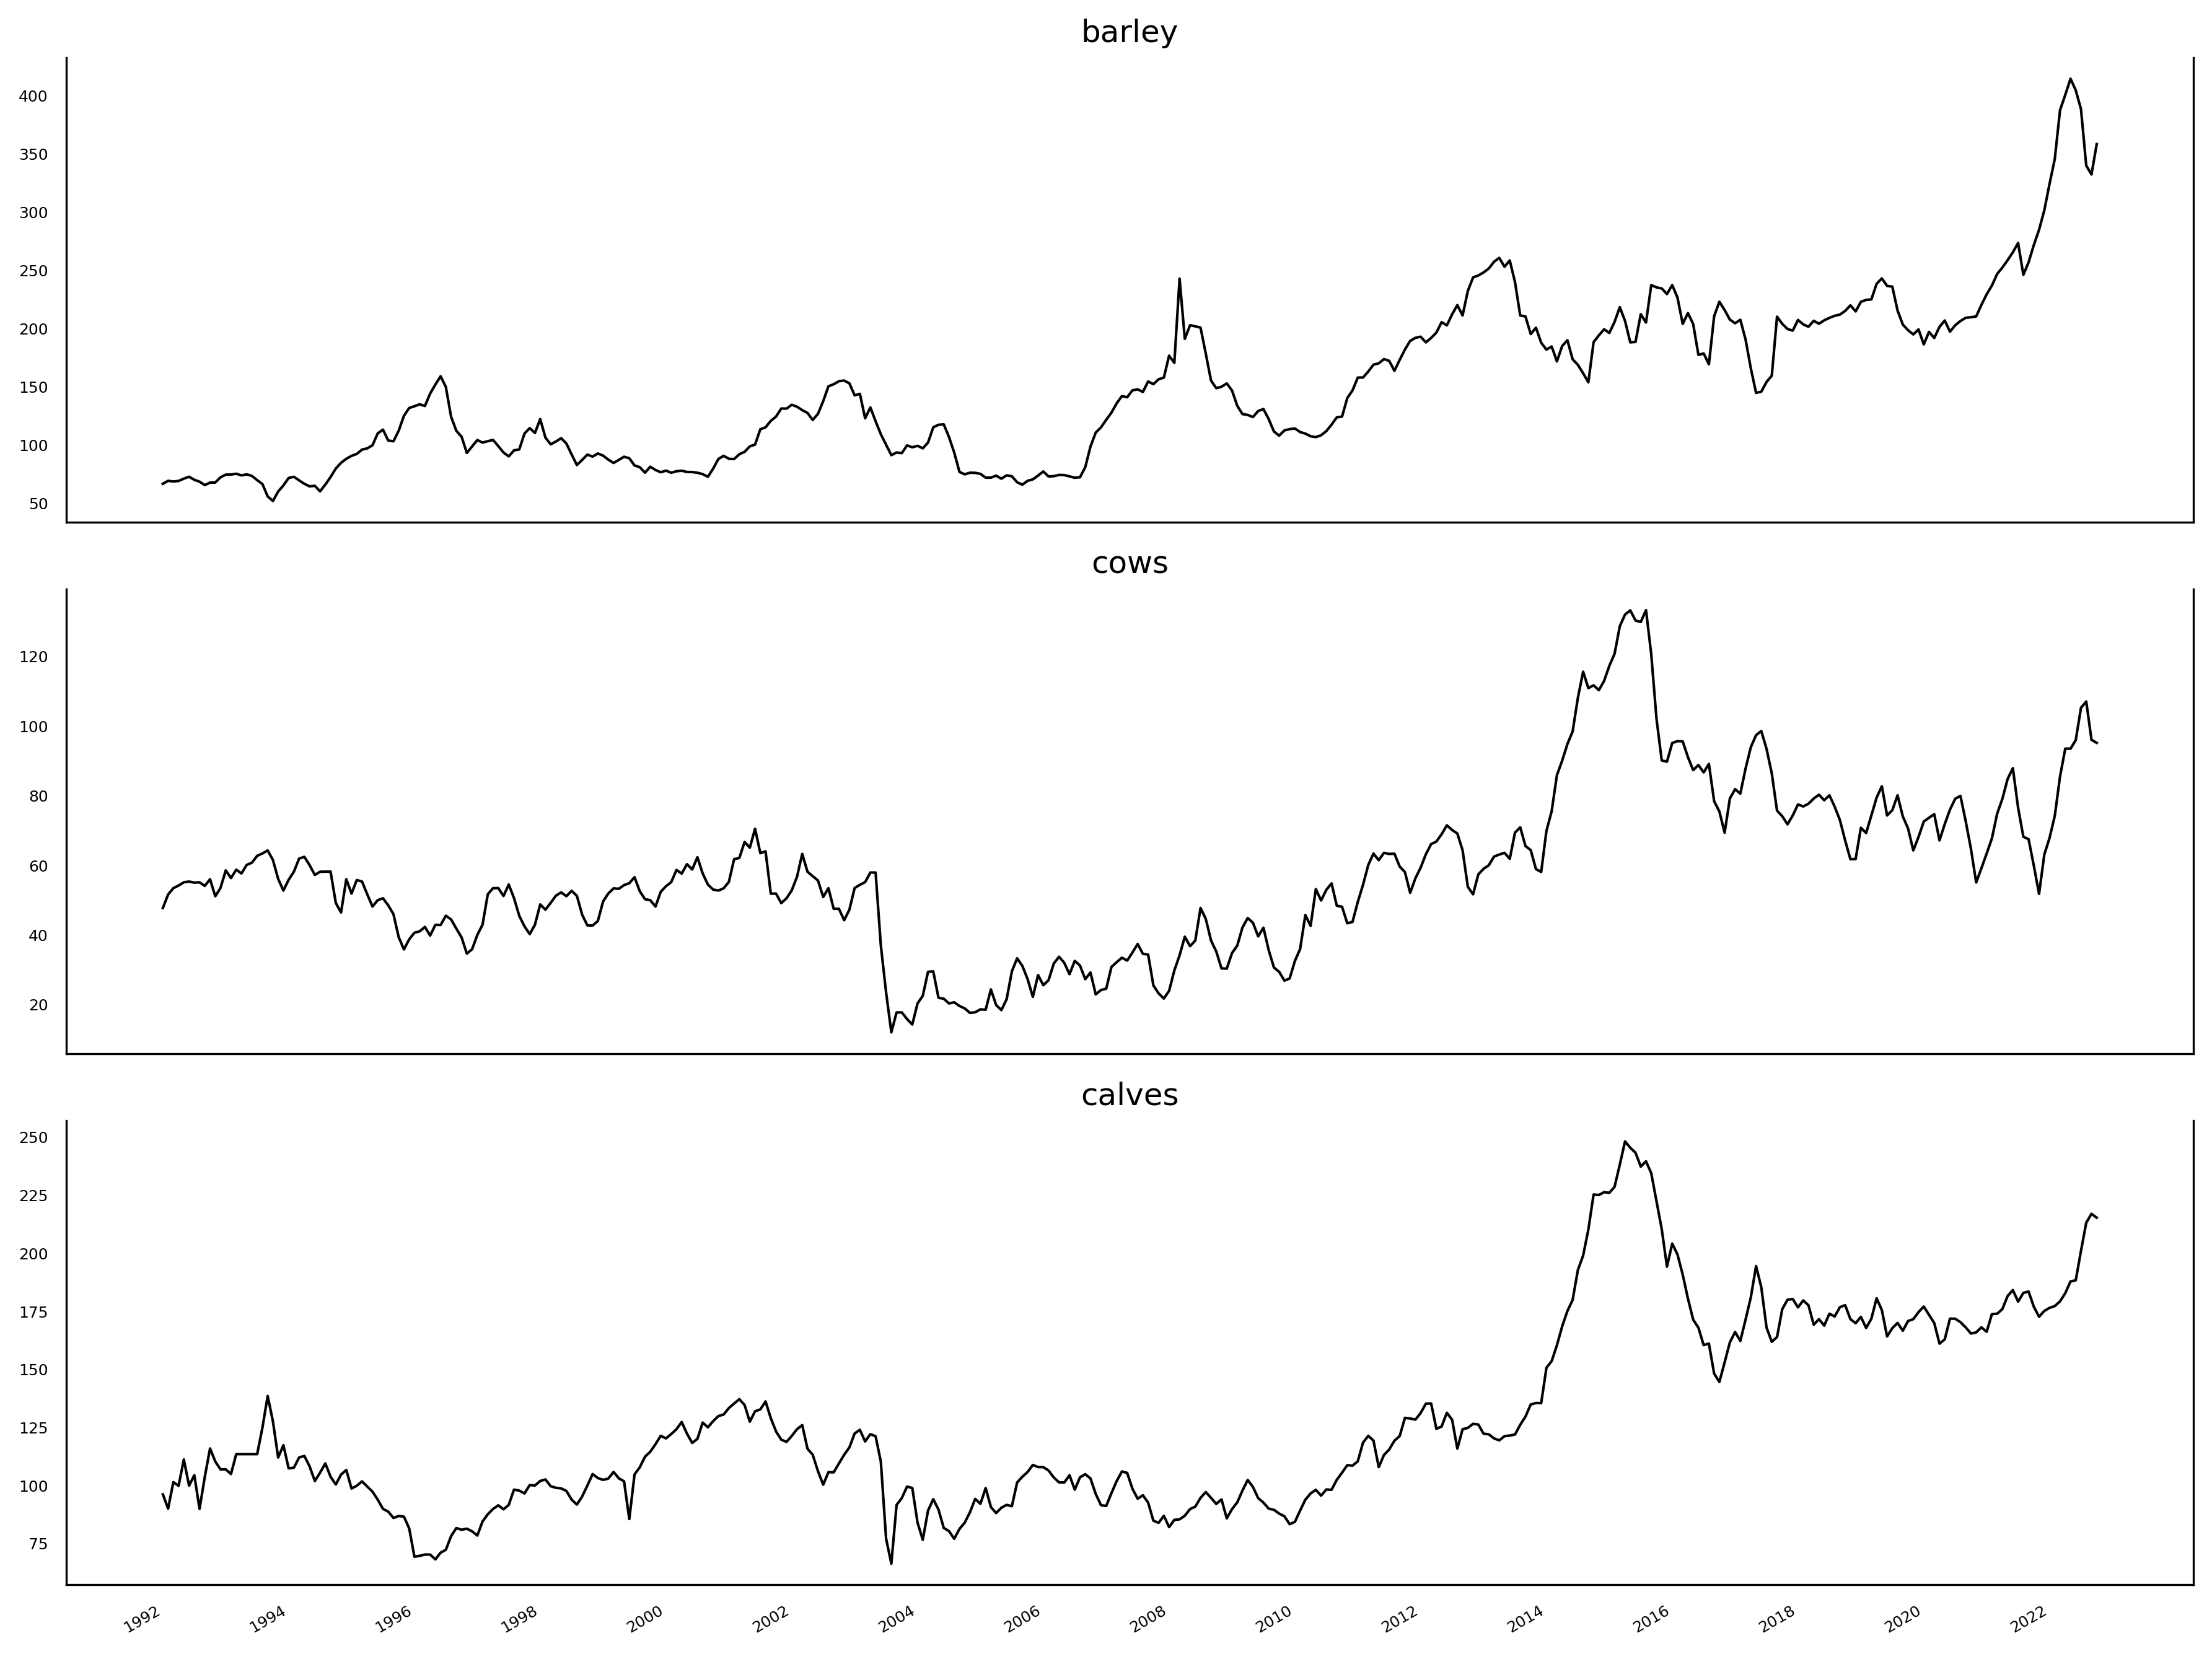

In [4]:
fig, axes = plt.subplots(nrows=3, ncols=1, dpi=300, figsize=(12,9))

for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i+1]]
    
    ax.plot(data, color='black', linewidth=1)
    ax.set_title(df.columns[i+1])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.setp(axes, xticks=np.arange(0, 369, 24), xticklabels=np.arange(1992, 2023, 2))

fig.autofmt_xdate()

plt.tight_layout()

## VAR(p) 

### Check for stationarity 

In [5]:
ad_fuller_result_1 = adfuller(df['cows'])

print('cows')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(df['calves'])

print('calves')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

cows
ADF Statistic: -1.824673327122963
p-value: 0.3682826880725826

---------------------

calves
ADF Statistic: -0.6797085372042213
p-value: 0.851935709412259


In [6]:
ad_fuller_result_1 = adfuller(df['cows'].diff()[1:])

print('cows')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(df['calves'].diff()[1:])

print('calves')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

cows
ADF Statistic: -3.9172400148092836
p-value: 0.001911570559956177

---------------------

calves
ADF Statistic: -5.358388855111447
p-value: 4.139911181465782e-06


### Model selection 

In [7]:
def VAR_gridsearch(endog, min_p, max_p):
    
    all_p = range(min_p, max_p +1, 1)
    
    results = []
    
    print(f'Fitting {all_p} unique models')
    
    for p in tqdm_notebook(all_p):
        try:
            model = VARMAX(endog, order=(p, 0)).fit(dips=False)
        except:
            continue
            
        results.append([p, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['p', 'AIC']
    
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [8]:
endog = df[['cows', 'calves']]

endog_diff = df[['cows', 'calves']].diff()[1:]

train = endog_diff[:-48]
test = endog_diff[-48:]

result_df = VAR_gridsearch(train, 0, 6)
result_df

Fitting range(0, 7) unique models


  0%|          | 0/7 [00:00<?, ?it/s]

,p,AIC
0,6,3857.399348
1,5,3864.637583
2,4,3865.935543
3,3,3872.751317
4,1,3882.225272
5,2,3884.240038


In [9]:
print('calves Granger-causes cows?\n')
print('------------------')
granger_1 = grangercausalitytests(df[['cows', 'calves']], [6])

print('\ncows Granger-causes calves?\n')
print('------------------')
granger_2 = grangercausalitytests(df[['calves', 'cows']], [6])

calves Granger-causes cows?

------------------

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=3.8994  , p=0.0009  , df_denom=351, df_num=6
ssr based chi2 test:   chi2=24.2630 , p=0.0005  , df=6
likelihood ratio test: chi2=23.4886 , p=0.0006  , df=6
parameter F test:         F=3.8994  , p=0.0009  , df_denom=351, df_num=6

cows Granger-causes calves?

------------------

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.3075  , p=0.0337  , df_denom=351, df_num=6
ssr based chi2 test:   chi2=14.3577 , p=0.0259  , df=6
likelihood ratio test: chi2=14.0818 , p=0.0287  , df=6
parameter F test:         F=2.3075  , p=0.0337  , df_denom=351, df_num=6


In [10]:
VAR_model = VARMAX(train, order=(6,0))
VAR_model_fit = VAR_model.fit(disp=False)

print(VAR_model_fit.summary())

                           Statespace Model Results                           
Dep. Variable:     ['cows', 'calves']   No. Observations:                  321
Model:                         VAR(6)   Log Likelihood               -1899.700
                          + intercept   AIC                           3857.399
Date:                Sun, 08 Jan 2023   BIC                           3966.771
Time:                        14:01:47   HQIC                          3901.069
Sample:                             0                                         
                                - 321                                         
Covariance Type:                  opg                                         
Ljung-Box (L1) (Q):             0.16, 0.05   Jarque-Bera (JB):        116.37, 48.74
Prob(Q):                        0.69, 0.81   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         2.22, 0.93   Skew:                     -0.49, -0.18
Prob(H) (two-sided):            0.00,

### Residuals analysis
#### cows

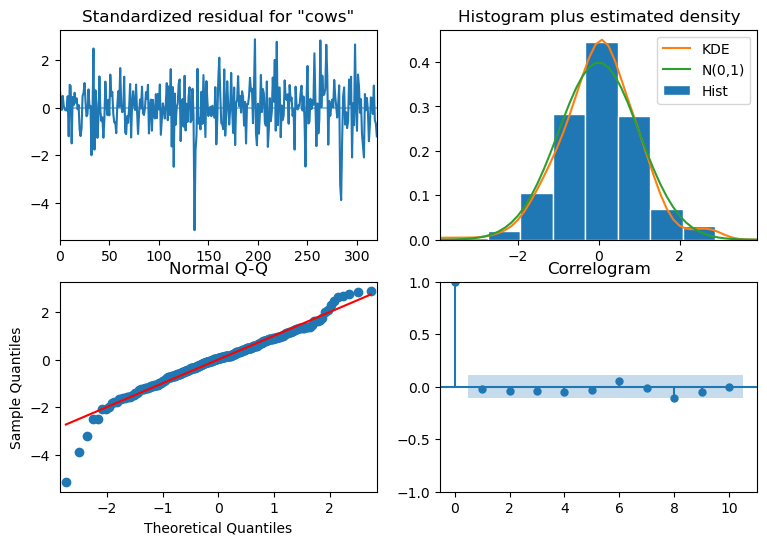

In [11]:
# cows
VAR_model_fit.plot_diagnostics(variable=0);

In [12]:
def ljung_box_test(residuals, is_seasonal, period):
    
    if is_seasonal:
        lb_df = acorr_ljungbox(residuals, period=period)
    else:
        max_lag = min([10, len(residuals)/5])
        
        lb_df = acorr_ljungbox(residuals, np.arange(1, max_lag+1, 1))

    fig, ax = plt.subplots()
    ax.plot(lb_df['lb_pvalue'], 'b-', label='p-values')
    ax.hlines(y=0.05, xmin=1, xmax=len(lb_df), color='black')
    plt.tight_layout()
    
    if all(pvalue > 0.05 for pvalue in lb_df['lb_pvalue']):
        print('All values are above 0.05. We fail to reject the null hypothesis. The residuals are uncorrelated')
    else:
        print('At least one p-value is smaller than 0.05')

All values are above 0.05. We fail to reject the null hypothesis. The residuals are uncorrelated


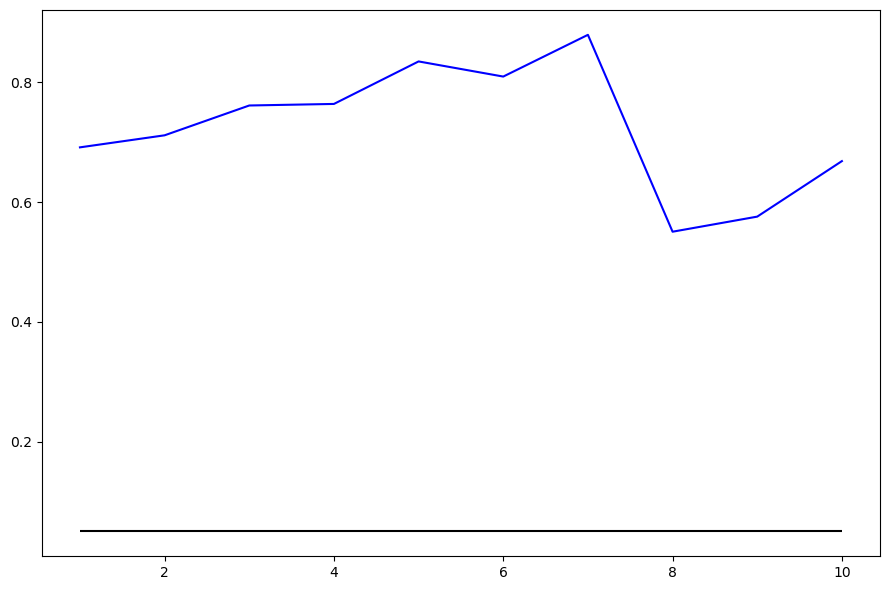

In [13]:
residuals = VAR_model_fit.resid['cows']

ljung_box_test(residuals, False, None)

#### calves 

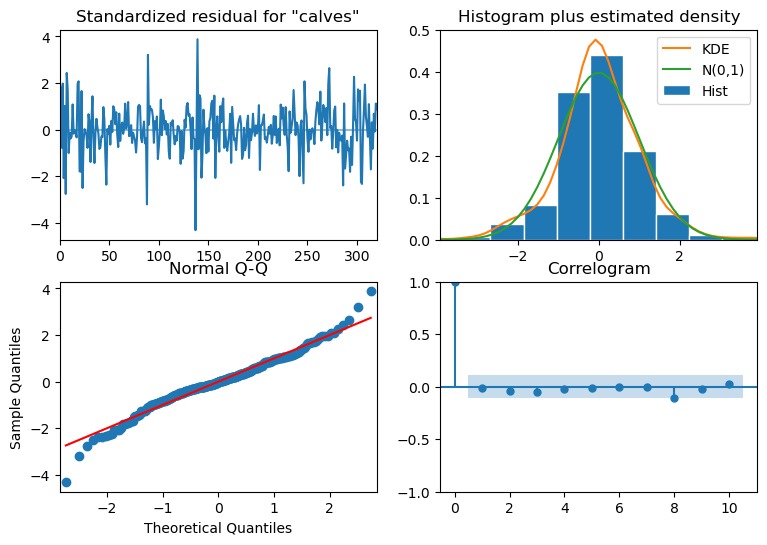

In [14]:
# calves
VAR_model_fit.plot_diagnostics(variable=1);

All values are above 0.05. We fail to reject the null hypothesis. The residuals are uncorrelated


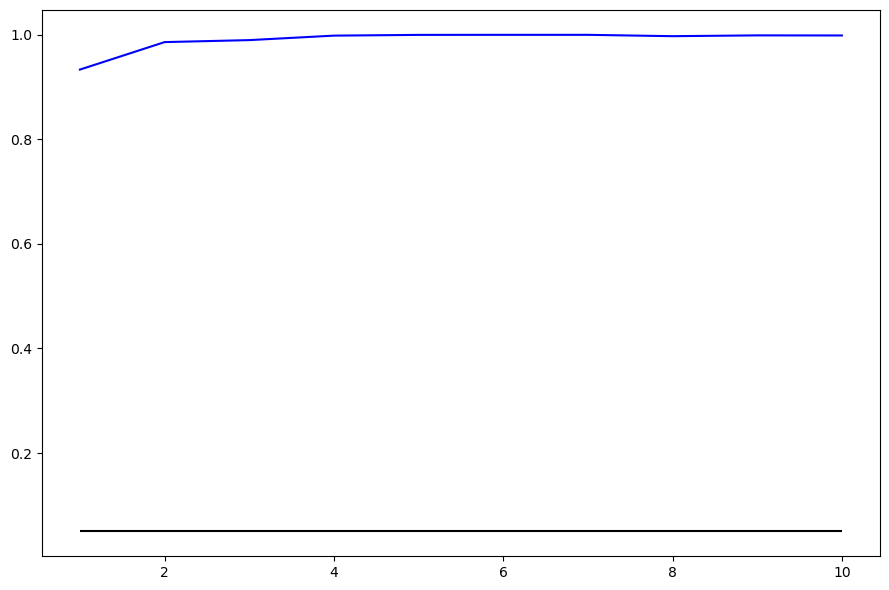

In [15]:
residuals = VAR_model_fit.resid['calves']

ljung_box_test(residuals, False, None)

### Forecasting

In [16]:
def rolling_predictions(df, last_train_value, train_len, horizon, window, method):
    
    total_len = train_len + horizon
    
    if method == 'VAR':

        cows_pred_VAR = []
        calves_pred_VAR = []
        
        for i in range(train_len, total_len, window):
            model = VARMAX(df[:i], order=(6,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            
            oos_pred_cows = predictions.predicted_mean.iloc[-window:]['cows']
            oos_pred_calves = predictions.predicted_mean.iloc[-window:]['calves']
            
            cows_pred_VAR.extend(oos_pred_cows)
            calves_pred_VAR.extend(oos_pred_calves)
            
        cows_pred_VAR = np.insert(cows_pred_VAR, 0, last_train_value['cows'])
        cows_pred_VAR = cows_pred_VAR.cumsum()
        
        calves_pred_VAR = np.insert(calves_pred_VAR, 0, last_train_value['calves'])
        calves_pred_VAR = calves_pred_VAR.cumsum()
        
        return cows_pred_VAR[:horizon], calves_pred_VAR[:horizon]
    
    elif method == 'last':
        cows_pred_last = []
        calves_pred_last = []
        
        for i in range(train_len, total_len, window):
            
            cows_last = df[:i].iloc[-1]['cows']
            calves_last = df[:i].iloc[-1]['calves']
            
            cows_pred_last.extend(cows_last for _ in range(window))
            calves_pred_last.extend(calves_last for _ in range(window))
        
        cows_pred_last = np.insert(cows_pred_last, 0, last_train_value['cows'])
        cows_pred_last = cows_pred_last.cumsum()
        
        calves_pred_last = np.insert(calves_pred_last, 0, last_train_value['calves'])
        calves_pred_last = calves_pred_last.cumsum()
            
        return cows_pred_last[:horizon], calves_pred_last[:horizon]

In [17]:
pred_df = df[['cows', 'calves']][-48:]

TRAIN_LEN = len(train)
HORIZON = len(test)
LAST_TRAIN_VALUE = endog.iloc[321]

windows = [1, 4, 6, 12]

for window in windows:
    cows_pred_last, calves_pred_last = rolling_predictions(endog_diff, LAST_TRAIN_VALUE, TRAIN_LEN, HORIZON, window, 'last')
    cows_pred_VAR, calves_pred_VAR = rolling_predictions(endog_diff, LAST_TRAIN_VALUE, TRAIN_LEN, HORIZON, window, 'VAR')
    
    pred_df[f'cows_pred_last_{window}'] = cows_pred_last
    pred_df[f'calves_pred_last_{window}'] = calves_pred_last
    pred_df[f'cows_pred_VAR_{window}'] = cows_pred_VAR
    pred_df[f'calves_pred_VAR_{window}'] = calves_pred_VAR
    
pred_df.head()

,cows,calves,cows_pred_last_1,calves_pred_last_1,cows_pred_VAR_1,calves_pred_VAR_1,cows_pred_last_4,calves_pred_last_4,cows_pred_VAR_4,calves_pred_VAR_4,cows_pred_last_6,calves_pred_last_6,cows_pred_VAR_6,calves_pred_VAR_6,cows_pred_last_12,calves_pred_last_12,cows_pred_VAR_12,calves_pred_VAR_12
322,61.81,171.68,67.17,177.70,67.170000,177.700000,67.17,177.70,67.170000,177.700000,67.17,177.70,67.170000,177.700000,67.17,177.70,67.170000,177.700000
323,61.85,169.94,61.30,178.56,66.948169,176.391738,61.30,178.56,66.948169,176.391738,61.30,178.56,66.948169,176.391738,61.30,178.56,66.948169,176.391738
324,70.84,172.67,55.94,172.54,67.358382,174.392420,55.43,179.42,68.581829,176.128407,55.43,179.42,68.581829,176.128407,55.43,179.42,68.581829,176.128407
325,69.34,167.90,55.98,170.80,69.223348,175.614713,49.56,180.28,71.353641,178.178357,49.56,180.28,71.353641,178.178357,49.56,180.28,71.353641,178.178357
326,74.36,171.88,64.97,173.53,73.689360,179.524382,43.69,181.14,74.045799,179.656663,43.69,181.14,74.045799,179.656663,43.69,181.14,74.045799,179.656663


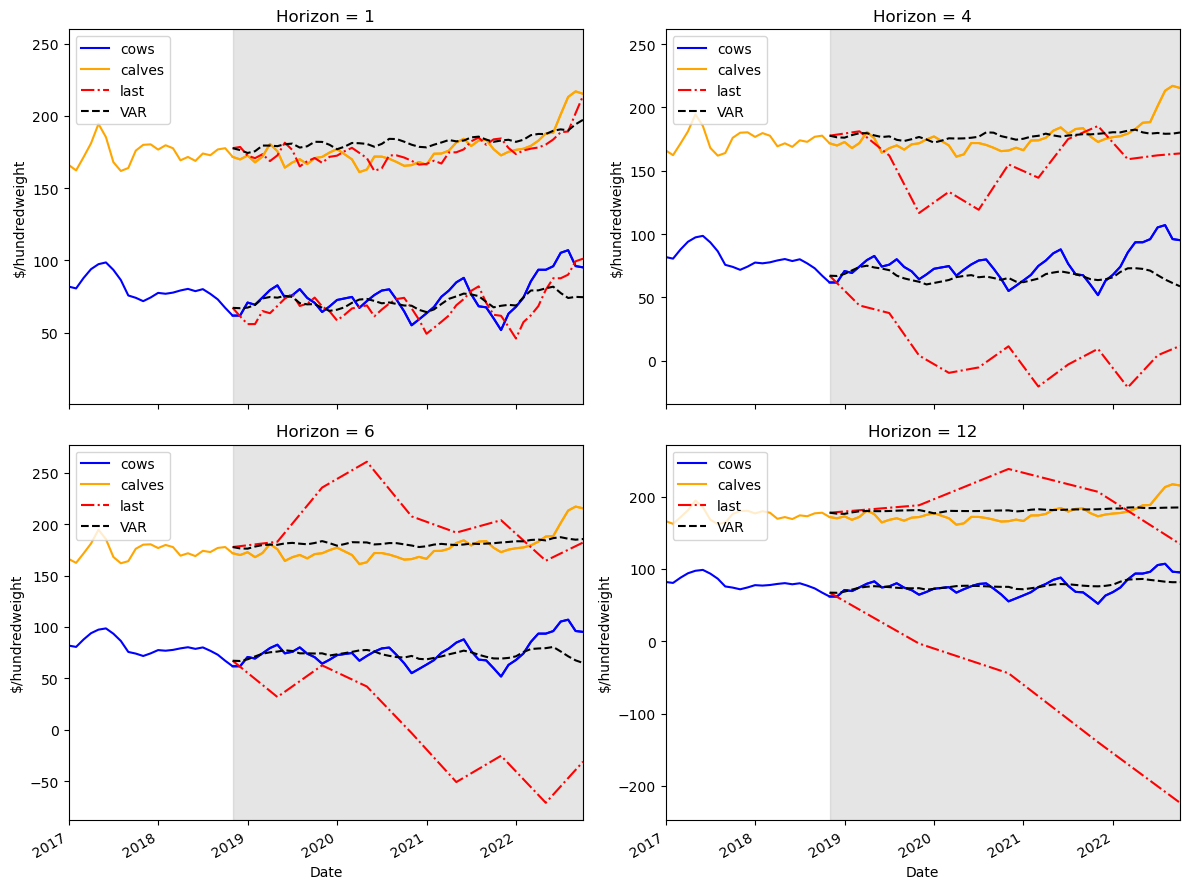

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

for i, ax in enumerate(axes.flatten()):
    
    ax.plot(df['cows'], color='blue')
    ax.plot(df['calves'], color='orange')
    ax.plot(pred_df['cows'], color='blue', label='cows')
    ax.plot(pred_df['calves'], color='orange', label='calves')
    ax.plot(pred_df[f'cows_pred_last_{windows[i]}'], 'r-.', label='last')
    ax.plot(pred_df[f'calves_pred_last_{windows[i]}'], 'r-.')
    ax.plot(pred_df[f'cows_pred_VAR_{windows[i]}'], 'k--', label='VAR')
    ax.plot(pred_df[f'calves_pred_VAR_{windows[i]}'], 'k--')
    ax.legend(loc=2)
    ax.set_xlabel('Date')
    ax.set_ylabel('$/hundredweight')
    ax.axvspan(322, 369, color='#808080', alpha=0.2)
    ax.set_xlim(300, 369)
    ax.set_title(f'Horizon = {windows[i]}')
    
plt.setp(axes, xticks=np.arange(300, 369, 12), xticklabels=np.arange(2017, 2023, 1))

fig.autofmt_xdate()
plt.tight_layout()

### Evaluation 

In [19]:
from sklearn.metrics import mean_absolute_error

mae_cow_last_1 = mean_absolute_error(pred_df['cows'], pred_df['cows_pred_last_1'])
mae_calves_last_1 = mean_absolute_error(pred_df['calves'], pred_df['calves_pred_last_1'])
mae_cow_VAR_1 = mean_absolute_error(pred_df['cows'], pred_df['cows_pred_VAR_1'])
mae_calves_VAR_1 = mean_absolute_error(pred_df['calves'], pred_df['calves_pred_VAR_1'])

mae_cow_last_4 = mean_absolute_error(pred_df['cows'], pred_df['cows_pred_last_4'])
mae_calves_last_4 = mean_absolute_error(pred_df['calves'], pred_df['calves_pred_last_4'])
mae_cow_VAR_4 = mean_absolute_error(pred_df['cows'], pred_df['cows_pred_VAR_4'])
mae_calves_VAR_4 = mean_absolute_error(pred_df['calves'], pred_df['calves_pred_VAR_4'])

mae_cow_last_6 = mean_absolute_error(pred_df['cows'], pred_df['cows_pred_last_6'])
mae_calves_last_6 = mean_absolute_error(pred_df['calves'], pred_df['calves_pred_last_6'])
mae_cow_VAR_6 = mean_absolute_error(pred_df['cows'], pred_df['cows_pred_VAR_6'])
mae_calves_VAR_6 = mean_absolute_error(pred_df['calves'], pred_df['calves_pred_VAR_6'])

mae_cow_last_12 = mean_absolute_error(pred_df['cows'], pred_df['cows_pred_last_12'])
mae_calves_last_12 = mean_absolute_error(pred_df['calves'], pred_df['calves_pred_last_12'])
mae_cow_VAR_12 = mean_absolute_error(pred_df['cows'], pred_df['cows_pred_VAR_12'])
mae_calves_VAR_12 = mean_absolute_error(pred_df['calves'], pred_df['calves_pred_VAR_12'])

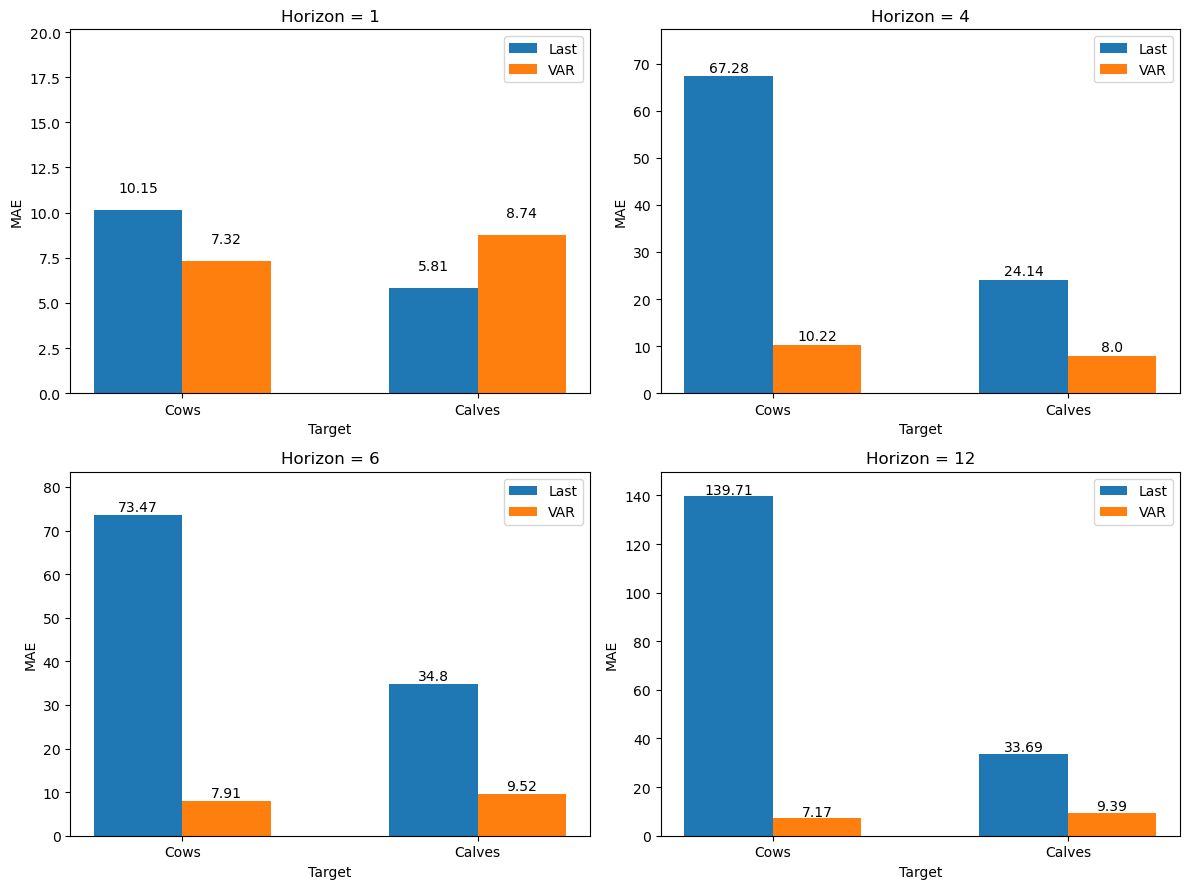

In [20]:
mae_cows_last = [mae_cow_last_1, mae_cow_last_4, mae_cow_last_6, mae_cow_last_12]
mae_calves_last = [mae_calves_last_1, mae_calves_last_4, mae_calves_last_6, mae_calves_last_12]
mae_cows_VAR = [mae_cow_VAR_1, mae_cow_VAR_4, mae_cow_VAR_6, mae_cow_VAR_12]
mae_calves_VAR = [mae_calves_VAR_1, mae_calves_VAR_4, mae_calves_VAR_6, mae_calves_VAR_12]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

width = 0.3
labels = ['Cows', 'Calves']
x = np.arange(len(labels))

for i, ax in enumerate(axes.flatten()):
    y_last = [mae_cows_last[i], mae_calves_last[i]]
    y_VAR = [mae_cows_VAR[i], mae_calves_VAR[i]]
    
    ax.bar(x - width/2, y_last, width, label='Last')
    ax.bar(x + width/2, y_VAR, width, label='VAR')
    
    ax.set_ylim(0, max(y_last) + 10)
    ax.set_ylabel('MAE')
    ax.set_xlabel('Target')
    ax.set_title(f'Horizon = {windows[i]}')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(loc='best')
    
    for i, v in enumerate(y_last):
        ax.text(x=i - width/2, y=v+1, s=str(round(v, 2)), ha='center')
    for i, v in enumerate(y_VAR):
        ax.text(x=i + width/2, y=v+1, s=str(round(v, 2)), ha='center')
    
plt.tight_layout()

## VARMA(p,q) 

In [21]:
def VARMA_gridsearch(endog, min_p, max_p, min_q, max_q):
    
    all_p = range(min_p, max_p+1, 1)
    all_q = range(min_q, max_q+1, 1)
    all_orders = list(product(all_p, all_q))
    
    results = []
    
    print(f'Fitting {len(all_orders)} unique models')
    
    for order in tqdm_notebook(all_orders):
        try:
            model = VARMAX(endog, order=order).fit(disp=False)
        except:
            continue
    
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [22]:
result_VARMA = VARMA_gridsearch(train, 0, 6, 0, 6)
result_VARMA.head()

Fitting 49 unique models


  0%|          | 0/49 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(6, 4)",3773.472122
1,"(6, 1)",3774.313326
2,"(5, 4)",3777.956500
3,"(4, 5)",3778.917425
4,"(6, 2)",3778.984492


We don't need to redo the Granger causality test, since $p=6$

In [23]:
VARMA_model = VARMAX(train, order=(6,4))
VARMA_model_fit = VARMA_model.fit(disp=False)

print(VARMA_model_fit.summary())

                           Statespace Model Results                           
Dep. Variable:     ['cows', 'calves']   No. Observations:                  321
Model:                     VARMA(6,4)   Log Likelihood               -1841.736
                          + intercept   AIC                           3773.472
Date:                Sun, 08 Jan 2023   BIC                           3943.187
Time:                        14:05:17   HQIC                          3841.235
Sample:                             0                                         
                                - 321                                         
Covariance Type:                  opg                                         
Ljung-Box (L1) (Q):             0.23, 0.88   Jarque-Bera (JB):        225.29, 49.32
Prob(Q):                        0.63, 0.35   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         2.37, 0.91   Skew:                     -0.64, -0.03
Prob(H) (two-sided):            0.00,

### Residuals analysis 

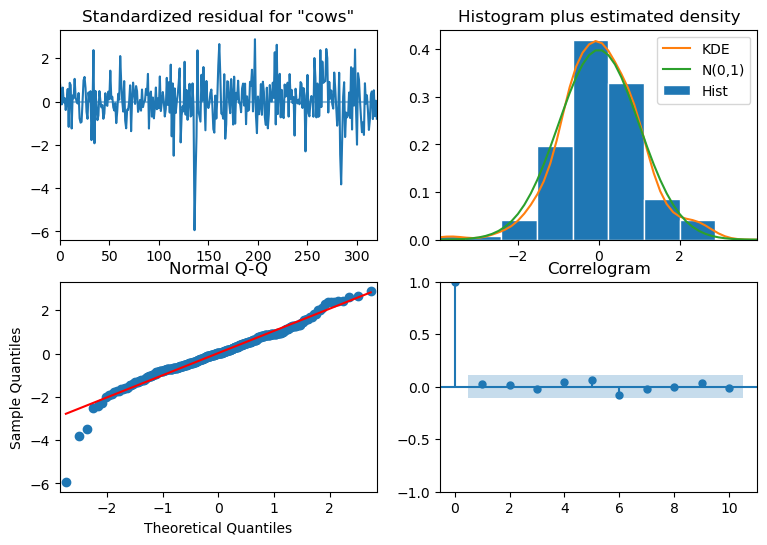

In [24]:
VARMA_model_fit.plot_diagnostics(variable=0);

All values are above 0.05. We fail to reject the null hypothesis. The residuals are uncorrelated


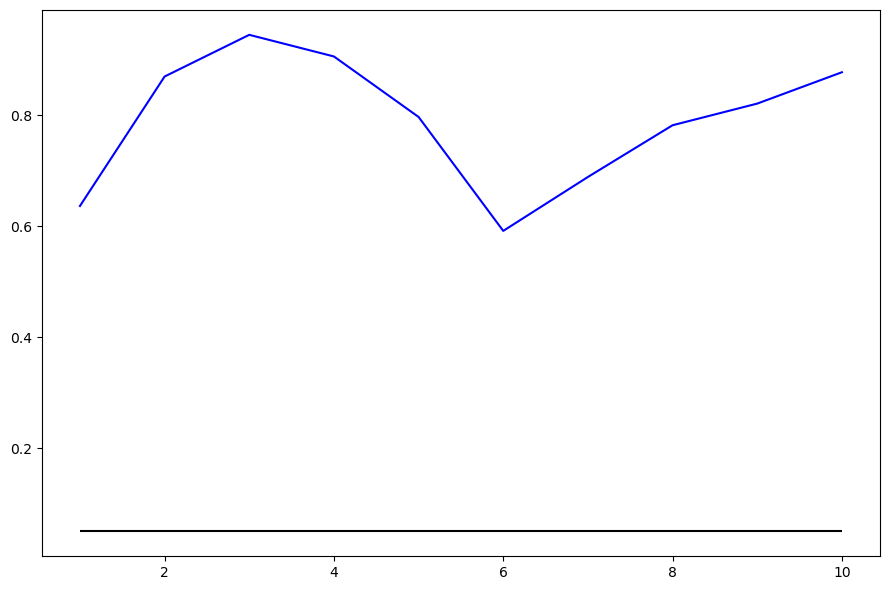

In [25]:
residuals = VARMA_model_fit.resid['cows']

ljung_box_test(residuals, False, None)

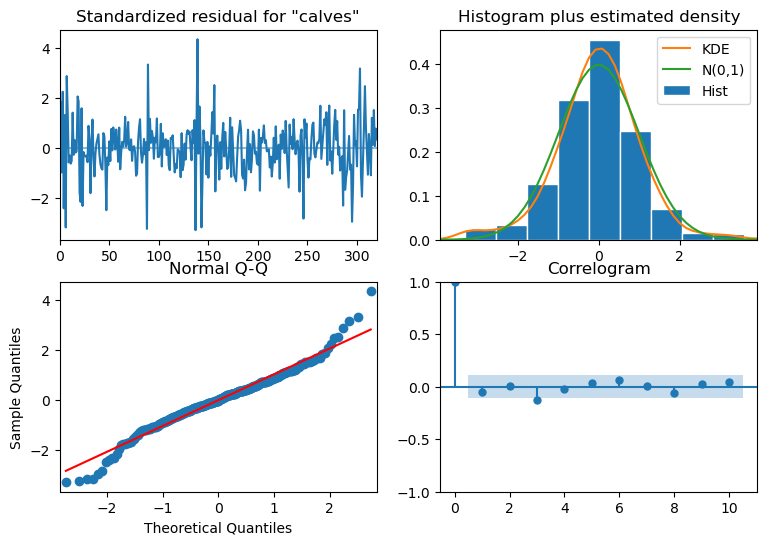

In [26]:
VARMA_model_fit.plot_diagnostics(variable=1);

At least one p-value is smaller than 0.05


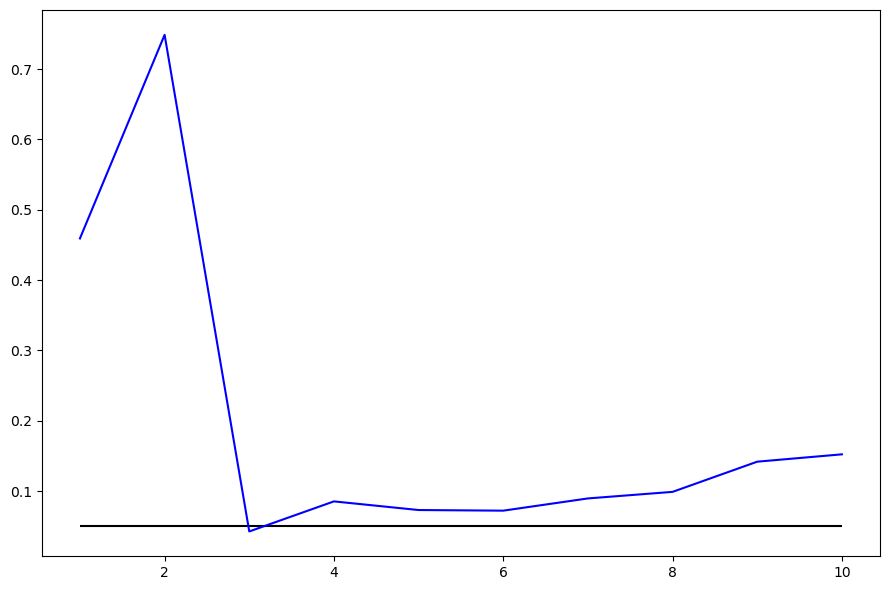

In [27]:
residuals = VARMA_model_fit.resid['calves']

ljung_box_test(residuals, False, None)

### Forecasting 

In [28]:
def rolling_predictions(df, last_train_value, train_len, horizon, window, method):
    
    total_len = train_len + horizon
    
    if method == 'VARMA':

        cows_pred_VARMA = []
        calves_pred_VARMA = []
        
        for i in range(train_len, total_len, window):
            model = VARMAX(df[:i], order=(6,4))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            
            oos_pred_cows = predictions.predicted_mean.iloc[-window:]['cows']
            oos_pred_calves = predictions.predicted_mean.iloc[-window:]['calves']
            
            cows_pred_VARMA.extend(oos_pred_cows)
            calves_pred_VARMA.extend(oos_pred_calves)
            
        cows_pred_VARMA = np.insert(cows_pred_VARMA, 0, last_train_value['cows'])
        cows_pred_VARMA = cows_pred_VARMA.cumsum()
        
        calves_pred_VARMA = np.insert(calves_pred_VARMA, 0, last_train_value['calves'])
        calves_pred_VARMA = calves_pred_VARMA.cumsum()
        
        return cows_pred_VARMA[:horizon], calves_pred_VARMA[:horizon]
    
    elif method == 'last':
        cows_pred_last = []
        calves_pred_last = []
        
        for i in range(train_len, total_len, window):
            
            cows_last = df[:i].iloc[-1]['cows']
            calves_last = df[:i].iloc[-1]['calves']
            
            cows_pred_last.extend(cows_last for _ in range(window))
            calves_pred_last.extend(calves_last for _ in range(window))
        
        cows_pred_last = np.insert(cows_pred_last, 0, last_train_value['cows'])
        cows_pred_last = cows_pred_last.cumsum()
        
        calves_pred_last = np.insert(calves_pred_last, 0, last_train_value['calves'])
        calves_pred_last = calves_pred_last.cumsum()
            
        return cows_pred_last[:horizon], calves_pred_last[:horizon]

In [29]:
pred_df = df[['cows', 'calves']][-48:]

TRAIN_LEN = len(train)
HORIZON = len(test)
LAST_TRAIN_VALUE = endog.iloc[321]

windows = [1, 4, 6, 12]

for window in windows:
    cows_pred_last, calves_pred_last = rolling_predictions(endog_diff, LAST_TRAIN_VALUE, TRAIN_LEN, HORIZON, window, 'last')
    cows_pred_VARMA, calves_pred_VARMA = rolling_predictions(endog_diff, LAST_TRAIN_VALUE, TRAIN_LEN, HORIZON, window, 'VARMA')
    
    pred_df[f'cows_pred_last_{window}'] = cows_pred_last
    pred_df[f'calves_pred_last_{window}'] = calves_pred_last
    pred_df[f'cows_pred_VARMA_{window}'] = cows_pred_VARMA
    pred_df[f'calves_pred_VARMA_{window}'] = calves_pred_VARMA
    
pred_df.head()

,cows,calves,cows_pred_last_1,calves_pred_last_1,cows_pred_VARMA_1,calves_pred_VARMA_1,cows_pred_last_4,calves_pred_last_4,cows_pred_VARMA_4,calves_pred_VARMA_4,cows_pred_last_6,calves_pred_last_6,cows_pred_VARMA_6,calves_pred_VARMA_6,cows_pred_last_12,calves_pred_last_12,cows_pred_VARMA_12,calves_pred_VARMA_12
322,61.81,171.68,67.17,177.70,67.170000,177.700000,67.17,177.70,67.170000,177.700000,67.17,177.70,67.170000,177.700000,67.17,177.70,67.170000,177.700000
323,61.85,169.94,61.30,178.56,65.405067,178.001884,61.30,178.56,65.405067,178.001884,61.30,178.56,65.405067,178.001884,61.30,178.56,65.405067,178.001884
324,70.84,172.67,55.94,172.54,65.232107,177.438316,55.43,179.42,65.751701,179.256765,55.43,179.42,65.751701,179.256765,55.43,179.42,65.751701,179.256765
325,69.34,167.90,55.98,170.80,67.381763,180.342102,49.56,180.28,68.774037,182.415466,49.56,180.28,68.774037,182.415466,49.56,180.28,68.774037,182.415466
326,74.36,171.88,64.97,173.53,69.589662,185.520999,43.69,181.14,71.930056,184.937039,43.69,181.14,71.930056,184.937039,43.69,181.14,71.930056,184.937039


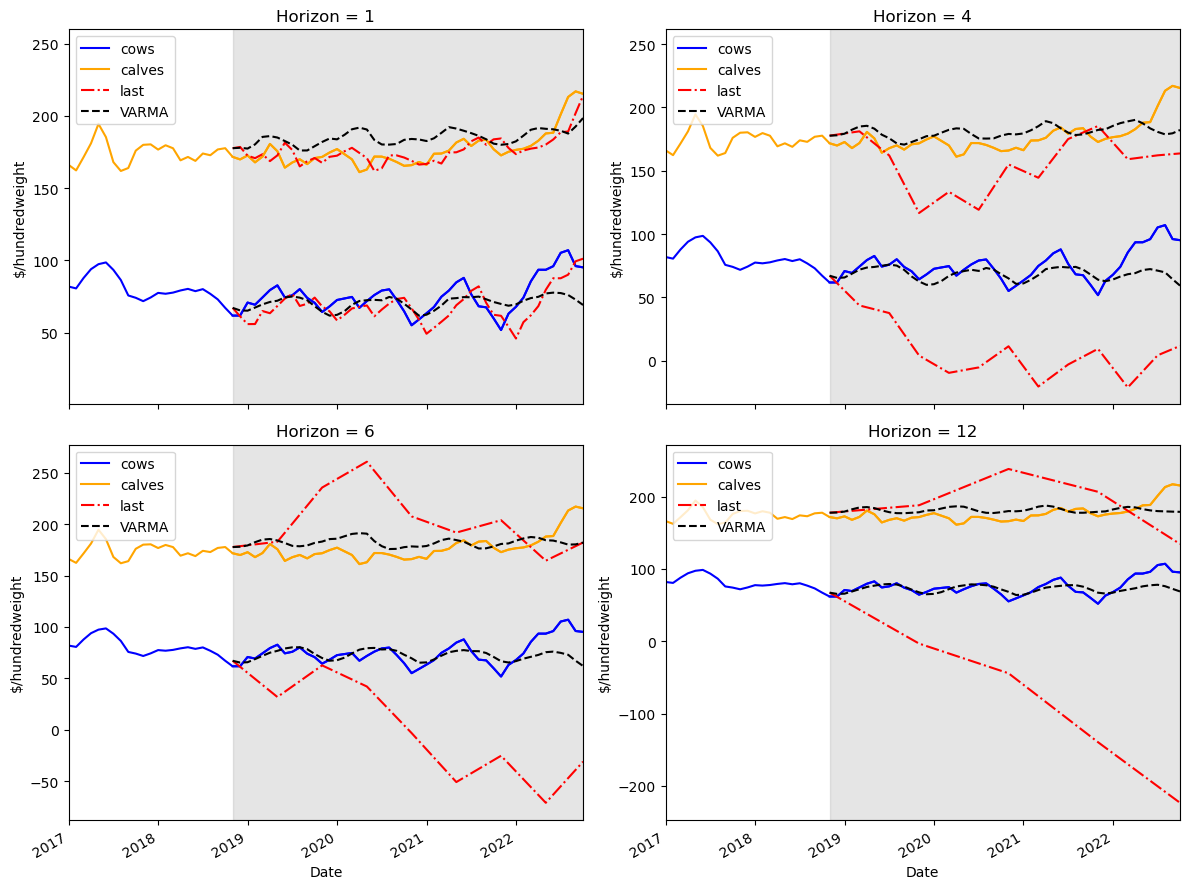

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

for i, ax in enumerate(axes.flatten()):
    
    ax.plot(df['cows'], color='blue')
    ax.plot(df['calves'], color='orange')
    ax.plot(pred_df['cows'], color='blue', label='cows')
    ax.plot(pred_df['calves'], color='orange', label='calves')
    ax.plot(pred_df[f'cows_pred_last_{windows[i]}'], 'r-.', label='last')
    ax.plot(pred_df[f'calves_pred_last_{windows[i]}'], 'r-.')
    ax.plot(pred_df[f'cows_pred_VARMA_{windows[i]}'], 'k--', label='VARMA')
    ax.plot(pred_df[f'calves_pred_VARMA_{windows[i]}'], 'k--')
    ax.legend(loc=2)
    ax.set_xlabel('Date')
    ax.set_ylabel('$/hundredweight')
    ax.axvspan(322, 369, color='#808080', alpha=0.2)
    ax.set_xlim(300, 369)
    ax.set_title(f'Horizon = {windows[i]}')
    
plt.setp(axes, xticks=np.arange(300, 369, 12), xticklabels=np.arange(2017, 2023, 1))

fig.autofmt_xdate()
plt.tight_layout()

### Evaluation 

In [31]:
mae_cow_last_1 = mean_absolute_error(pred_df['cows'], pred_df['cows_pred_last_1'])
mae_calves_last_1 = mean_absolute_error(pred_df['calves'], pred_df['calves_pred_last_1'])
mae_cow_VARMA_1 = mean_absolute_error(pred_df['cows'], pred_df['cows_pred_VARMA_1'])
mae_calves_VARMA_1 = mean_absolute_error(pred_df['calves'], pred_df['calves_pred_VARMA_1'])

mae_cow_last_4 = mean_absolute_error(pred_df['cows'], pred_df['cows_pred_last_4'])
mae_calves_last_4 = mean_absolute_error(pred_df['calves'], pred_df['calves_pred_last_4'])
mae_cow_VARMA_4 = mean_absolute_error(pred_df['cows'], pred_df['cows_pred_VARMA_4'])
mae_calves_VARMA_4 = mean_absolute_error(pred_df['calves'], pred_df['calves_pred_VARMA_4'])

mae_cow_last_6 = mean_absolute_error(pred_df['cows'], pred_df['cows_pred_last_6'])
mae_calves_last_6 = mean_absolute_error(pred_df['calves'], pred_df['calves_pred_last_6'])
mae_cow_VARMA_6 = mean_absolute_error(pred_df['cows'], pred_df['cows_pred_VARMA_6'])
mae_calves_VARMA_6 = mean_absolute_error(pred_df['calves'], pred_df['calves_pred_VARMA_6'])

mae_cow_last_12 = mean_absolute_error(pred_df['cows'], pred_df['cows_pred_last_12'])
mae_calves_last_12 = mean_absolute_error(pred_df['calves'], pred_df['calves_pred_last_12'])
mae_cow_VARMA_12 = mean_absolute_error(pred_df['cows'], pred_df['cows_pred_VARMA_12'])
mae_calves_VARMA_12 = mean_absolute_error(pred_df['calves'], pred_df['calves_pred_VARMA_12'])

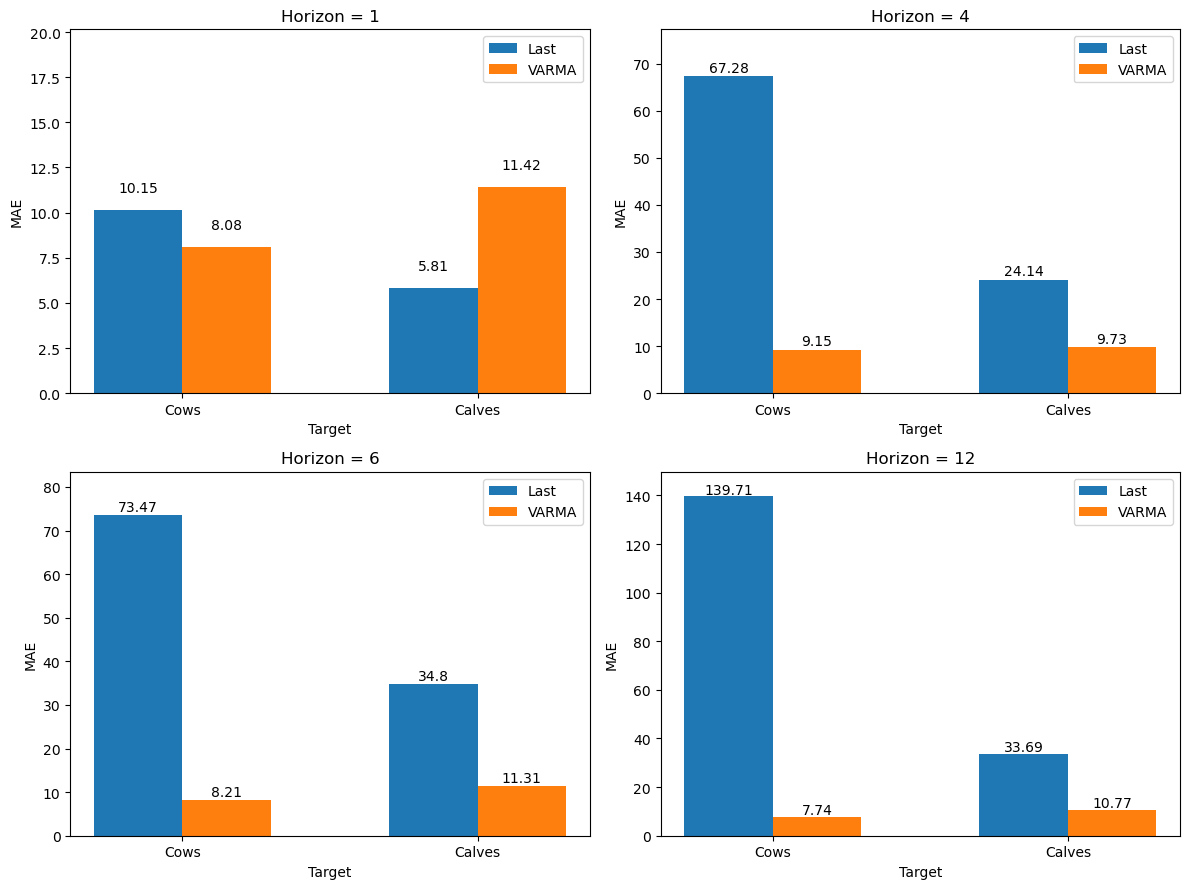

In [32]:
mae_cows_last = [mae_cow_last_1, mae_cow_last_4, mae_cow_last_6, mae_cow_last_12]
mae_calves_last = [mae_calves_last_1, mae_calves_last_4, mae_calves_last_6, mae_calves_last_12]
mae_cows_VARMA = [mae_cow_VARMA_1, mae_cow_VARMA_4, mae_cow_VARMA_6, mae_cow_VARMA_12]
mae_calves_VARMA = [mae_calves_VARMA_1, mae_calves_VARMA_4, mae_calves_VARMA_6, mae_calves_VARMA_12]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

width = 0.3
labels = ['Cows', 'Calves']
x = np.arange(len(labels))

for i, ax in enumerate(axes.flatten()):
    y_last = [mae_cows_last[i], mae_calves_last[i]]
    y_VARMA = [mae_cows_VARMA[i], mae_calves_VARMA[i]]
    
    ax.bar(x - width/2, y_last, width, label='Last')
    ax.bar(x + width/2, y_VARMA, width, label='VARMA')
    
    ax.set_ylim(0, max(y_last) + 10)
    ax.set_ylabel('MAE')
    ax.set_xlabel('Target')
    ax.set_title(f'Horizon = {windows[i]}')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(loc='best')
    
    for i, v in enumerate(y_last):
        ax.text(x=i - width/2, y=v+1, s=str(round(v, 2)), ha='center')
    for i, v in enumerate(y_VARMA):
        ax.text(x=i + width/2, y=v+1, s=str(round(v, 2)), ha='center')
    
plt.tight_layout()

## VARMAX 

In [33]:
def VARMAX_gridsearch(endog, exog, min_p, max_p, min_q, max_q):
    
    all_p = range(min_p, max_p+1, 1)
    all_q = range(min_q, max_q+1, 1)
    all_orders = list(product(all_p, all_q))
    
    print(f'Fitting {len(all_orders)} unique models')
    
    results = []
    
    for order in tqdm_notebook(all_orders):
        try:
            model = VARMAX(endog, exog, order=order).fit(disp=False)
        except:
            continue
    
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [34]:
# Index of exog must align with the training set
exog = df['barley'].iloc[1:322]

result_VARMAX = VARMAX_gridsearch(train, exog, 0, 6, 0, 6)
result_VARMAX.head()

Fitting 49 unique models


  0%|          | 0/49 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(6, 4)",3841.370903
1,"(6, 1)",3841.706027
2,"(6, 5)",3845.765687
3,"(6, 2)",3847.995580
4,"(3, 1)",3851.816608


We don't need to redo the Granger causality test since $p=6$

In [35]:
VARMAX_model = VARMAX(train, exog,  order=(6,4))
VARMAX_model_fit = VARMAX_model.fit(disp=False)

print(VARMAX_model_fit.summary())

                           Statespace Model Results                           
Dep. Variable:     ['cows', 'calves']   No. Observations:                  321
Model:                    VARMAX(6,4)   Log Likelihood               -1873.685
                          + intercept   AIC                           3841.371
Date:                Sun, 08 Jan 2023   BIC                           4018.629
Time:                        14:16:45   HQIC                          3912.146
Sample:                             0                                         
                                - 321                                         
Covariance Type:                  opg                                         
Ljung-Box (L1) (Q):             0.00, 0.74   Jarque-Bera (JB):        124.69, 40.12
Prob(Q):                        0.96, 0.39   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         2.49, 0.93   Skew:                     -0.52, -0.15
Prob(H) (two-sided):            0.00,

### Residuals analysis 

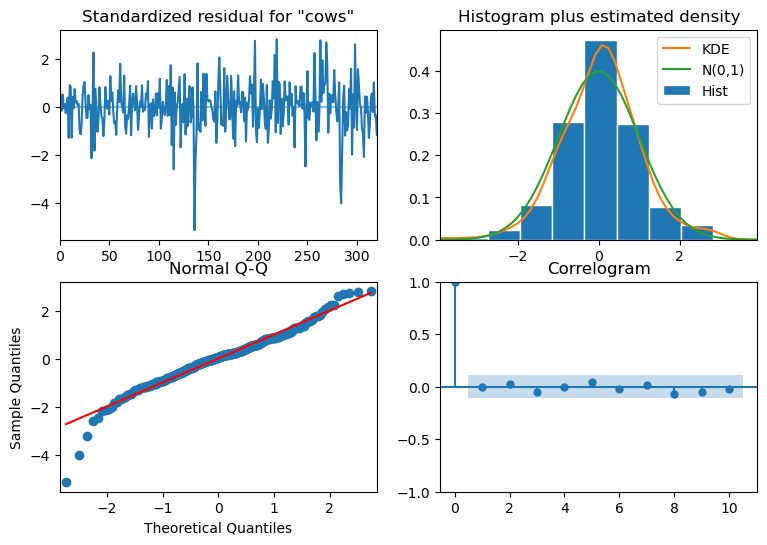

In [36]:
# cows
VARMAX_model_fit.plot_diagnostics(variable=0);

All values are above 0.05. We fail to reject the null hypothesis. The residuals are uncorrelated


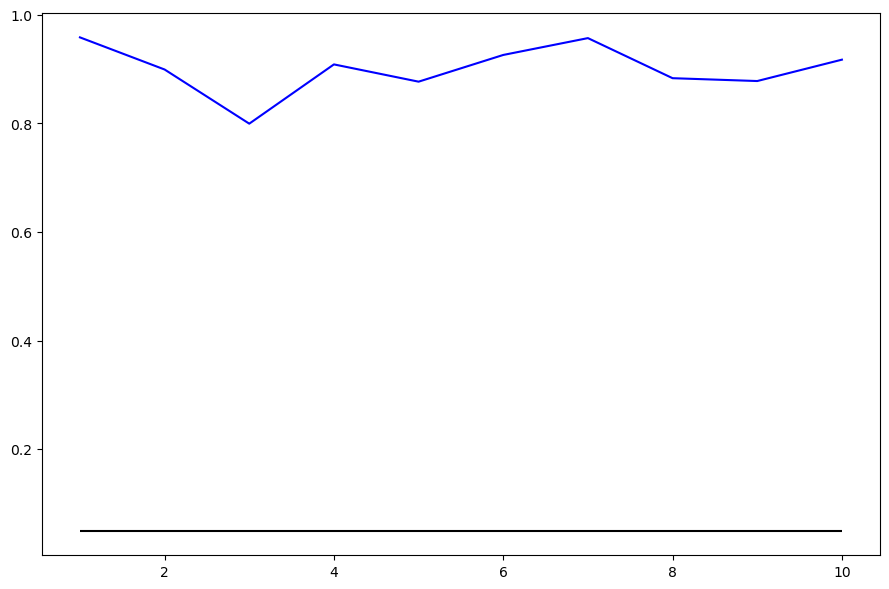

In [37]:
residuals = VARMAX_model_fit.resid['cows']

ljung_box_test(residuals, False, None)

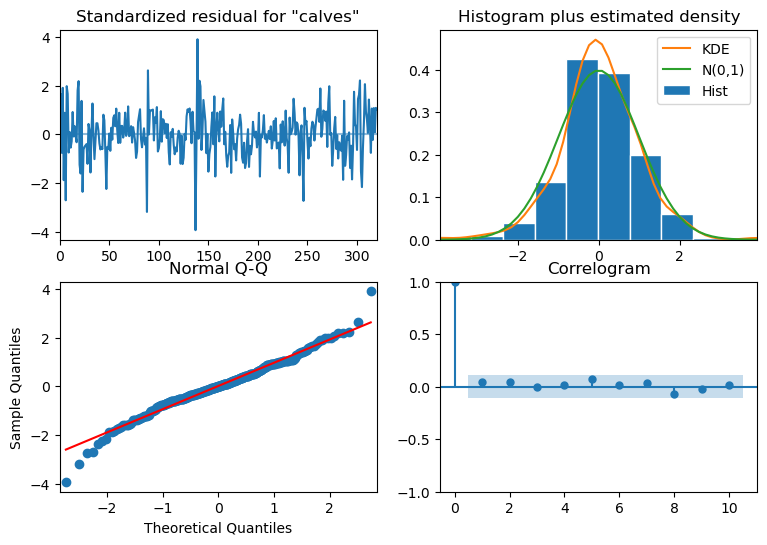

In [38]:
# calves
VARMAX_model_fit.plot_diagnostics(variable=1);

All values are above 0.05. We fail to reject the null hypothesis. The residuals are uncorrelated


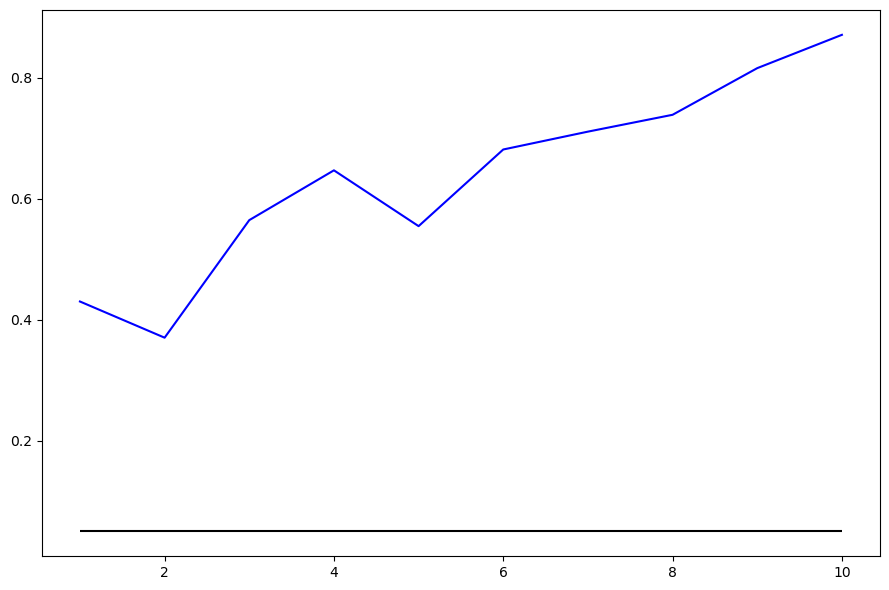

In [39]:
residuals = VARMAX_model_fit.resid['calves']

ljung_box_test(residuals, False, None)

### Forecasting 

In [40]:
def rolling_predictions(df, exog, last_train_value, train_len, horizon, window, method):
    
    total_len = train_len + horizon
    
    if method == 'VARMAX':

        cows_pred_VARMAX = []
        calves_pred_VARMAX = []
        
        for i in range(train_len, total_len, window):
            model = VARMAX(df[:i], exog[:i], order=(6,4))
            res = model.fit(disp=False)
            predictions = res.get_prediction(exog=exog[:i])
            
            oos_pred_cows = predictions.predicted_mean.iloc[-window:]['cows']
            oos_pred_calves = predictions.predicted_mean.iloc[-window:]['calves']
            
            cows_pred_VARMAX.extend(oos_pred_cows)
            calves_pred_VARMAX.extend(oos_pred_calves)
            
        cows_pred_VARMAX = np.insert(cows_pred_VARMAX, 0, last_train_value['cows'])
        cows_pred_VARMAX = cows_pred_VARMAX.cumsum()
        
        calves_pred_VARMAX = np.insert(calves_pred_VARMAX, 0, last_train_value['calves'])
        calves_pred_VARMAX = calves_pred_VARMAX.cumsum()
        
        return cows_pred_VARMAX[:horizon], calves_pred_VARMAX[:horizon]
    
    elif method == 'last':
        cows_pred_last = []
        calves_pred_last = []
        
        for i in range(train_len, total_len, window):
            
            cows_last = df[:i].iloc[-1]['cows']
            calves_last = df[:i].iloc[-1]['calves']
            
            cows_pred_last.extend(cows_last for _ in range(window))
            calves_pred_last.extend(calves_last for _ in range(window))
        
        cows_pred_last = np.insert(cows_pred_last, 0, last_train_value['cows'])
        cows_pred_last = cows_pred_last.cumsum()
        
        calves_pred_last = np.insert(calves_pred_last, 0, last_train_value['calves'])
        calves_pred_last = calves_pred_last.cumsum()
            
        return cows_pred_last[:horizon], calves_pred_last[:horizon]

In [41]:
pred_df = df[['cows', 'calves']][-48:]
exog = df['barley'][1:]

TRAIN_LEN = len(train)
HORIZON = len(test)
LAST_TRAIN_VALUE = endog.iloc[321]
WINDOW = 1

cows_pred_last, calves_pred_last = rolling_predictions(endog_diff, exog, LAST_TRAIN_VALUE, TRAIN_LEN, HORIZON, WINDOW, 'last')
cows_pred_VARMAX, calves_pred_VARMAX = rolling_predictions(endog_diff, exog, LAST_TRAIN_VALUE, TRAIN_LEN, HORIZON, WINDOW, 'VARMAX')
    
pred_df[f'cows_pred_last'] = cows_pred_last
pred_df[f'calves_pred_last'] = calves_pred_last
pred_df[f'cows_pred_VARMAX'] = cows_pred_VARMAX
pred_df[f'calves_pred_VARMAX'] = calves_pred_VARMAX
    
pred_df.head()

,cows,calves,cows_pred_last,calves_pred_last,cows_pred_VARMAX,calves_pred_VARMAX
322,61.81,171.68,67.17,177.70,67.170000,177.700000
323,61.85,169.94,61.30,178.56,65.831078,175.523071
324,70.84,172.67,55.94,172.54,64.725269,173.378706
325,69.34,167.90,55.98,170.80,64.259661,170.069073
326,74.36,171.88,64.97,173.53,66.000936,170.408344


### Evaluation 

In [42]:
mae_cow_last = mean_absolute_error(pred_df['cows'], pred_df['cows_pred_last'])
mae_calves_last = mean_absolute_error(pred_df['calves'], pred_df['calves_pred_last'])
mae_cow_VARMAX = mean_absolute_error(pred_df['cows'], pred_df['cows_pred_VARMAX'])
mae_calves_VARMAX = mean_absolute_error(pred_df['calves'], pred_df['calves_pred_VARMAX'])

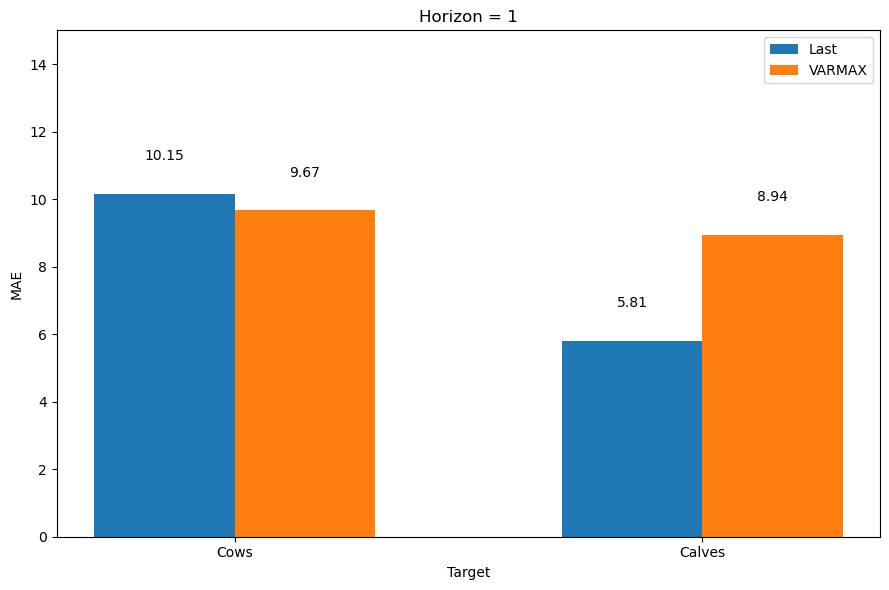

In [43]:
fig, ax = plt.subplots()

width = 0.3
labels = ['Cows', 'Calves']
x = np.arange(len(labels))

y_last = [mae_cow_last, mae_calves_last]
y_VARMAX = [mae_cow_VARMAX, mae_calves_VARMAX]

ax.bar(x - width/2, y_last, width, label='Last')
ax.bar(x + width/2, y_VARMAX, width, label='VARMAX')

ax.set_ylim(0, 15)
ax.set_ylabel('MAE')
ax.set_xlabel('Target')
ax.set_title(f'Horizon = 1')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='best')

for i, v in enumerate(y_last):
    ax.text(x=i - width/2, y=v+1, s=str(round(v, 2)), ha='center')
for i, v in enumerate(y_VARMAX):
    ax.text(x=i + width/2, y=v+1, s=str(round(v, 2)), ha='center')
    
plt.tight_layout()